### Notebook description

for this notebook, use a ss soil cover in dynamic equilibrium

Import the modules used in this notebook

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from autograd import grad
import autograd.numpy as np # automatic differentiation library
import matplotlib.gridspec as gridspec
from scipy.optimize import curve_fit

## PART I
### Creating a model hillslope

In [19]:
def f(x):
    return 1/(1 + np.exp(-x))

In [71]:
mu, sigma = 0, 10 
s1 = np.random.normal(mu, sigma, 20)

In [72]:
x = np.linspace(0,5,20)
sap = (f(x) *1000)+ s1
ss_surf = (f(x)+0.2)*1000

In [73]:
f1 = grad(f) # 1st derivative
f2 = grad(f1) # 2nd derivative

In [74]:
def curvature(x):
    return abs(f2(x))*(1 + f1(x)**2)**-1.5

In [75]:
c = [curvature(t) for t in x]
c = np.array(c)

In [76]:
h1_curv1 = ((f(x) + f(x)*-c**(2))*1.15)*1000

In [77]:
h1_curv2 = ((f(x) + f(x)*-c**(1.5))*1.15)*1000

In [78]:
h1_curv3 = ((f(x) + f(x)*-c**(1.2))*1.15)*1000

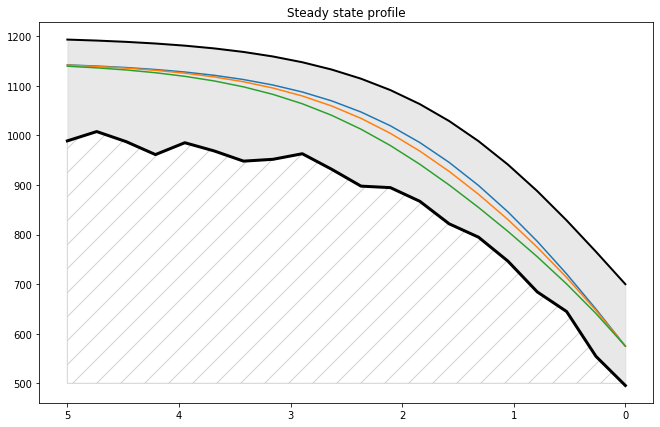

In [79]:
fig, ax = plt.subplots(figsize=(11,7))

# Plot initial conditions -------------------------------------------------
ax.plot(x, sap, color='k', linewidth=3) # soil-saprolite interface
ax.fill_between(x, 500, sap, facecolor='white', hatch='/', edgecolor='lightgrey') # color in bedrock


ax.plot(x, ss_surf, color='k', linewidth=2) # sub-aerial soil interface
ax.fill_between(x, sap, ss_surf, alpha=0.5, color='lightgrey') # color in soil

ax.plot(x, h1_curv1)
ax.plot(x, h1_curv2)
ax.plot(x, h1_curv3)

ax.invert_xaxis()
#ax.set_axis_off()
ax.set_title('Steady state profile')
plt.show()

In [80]:
sz = zip(x, sap, ss_surf-sap, h1_curv1-sap, h1_curv2-sap, h1_curv3-sap)
ss = pd.DataFrame(data=sz, columns=['x', 'sap', 'ss', 'c1', 'c2', 'c3'])

In [81]:
def p_rate(i):
    return 9.8 * np.exp(-i*1.6/165)

In [82]:
ss['ss_p'] = ss['ss'].apply(p_rate)
ss['c1_p'] = ss['c1'].apply(p_rate)
ss['c2_p'] = ss['c2'].apply(p_rate)
ss['c3_p'] = ss['c3'].apply(p_rate)

Calculate the nuclide concentration at depth $z$ from **equation 2**:
### $C_z = P_z  \left( \frac{1}{\lambda + \frac{\rho \in}{\Lambda}} \right)$

#### Constants:

$\lambda$ = $^{10}$Be decay constant = approximated as 0 for this simulation

$\in$ = Erosion rate = 1 [cm yr-1] for this simulation

In [83]:
def c_z(p):
    return p/(1.6/165)

In [84]:
ss['ss_c'] = ss['ss_p'].apply(c_z)

In [85]:
cz = 145.31885

Calculate the apparent erosion rate from $C_z$ using **equation 3**:

### $E_z = \left( \frac {\Lambda}{\rho} \right) \left( \frac{P_z}{C_z} \right)$

In [86]:
ss['ss_spr'] = (165/1.6) *(ss['ss_p']/cz)
ss['c1_spr'] = (165/1.6) *(ss['c1_p']/cz)
ss['c2_spr'] = (165/1.6) *(ss['c2_p']/cz)
ss['c3_spr'] = (165/1.6) *(ss['c3_p']/cz)

In [87]:
def fit(x, a, k):
    return a* np.exp(-k *x)

### Steady state soil production as initial condition:

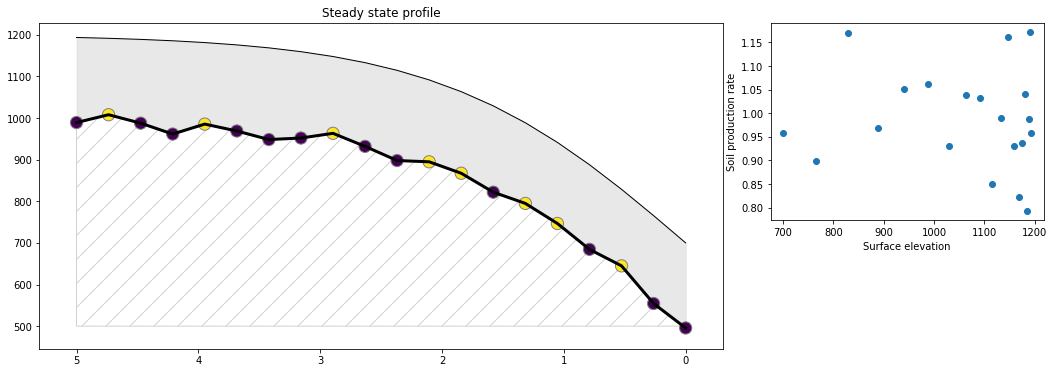

In [88]:
fig = plt.figure(figsize=(18,6))
gs = fig.add_gridspec(2,2, height_ratios=(1, 0.5), width_ratios=(2.5,1), wspace=0.1)
ax = fig.add_subplot(gs[:,0])
ax1 = fig.add_subplot(gs[0,1])

ax.plot(x, sap, color='k', linewidth=3) # soil-saprolite interface
ax.fill_between(x, 500, sap, facecolor='white', hatch='/', edgecolor='lightgrey') # color in bedrock


ax.plot(x, ss_surf, color='k', linewidth=1) # sub-aerial soil interface
ax.fill_between(x, sap, ss_surf, alpha=0.5, color='lightgrey') # color in soil

# Scatter plot of soil production rates ---------------------------------------

ax.scatter(x, sap, c=ss['ss_spr'].astype(int), s=150, edgecolor='grey')

# Plot params ---------------------------------------------------------------------

ax.invert_xaxis()
#ax.set_axis_off()
ax.set_title('Steady state profile')

# SPF plot ---------------------------------------------------------------------

ax1.plot(sap+ss['ss'], ss['ss_spr'], marker='o', linestyle='')

ax1.set_xlabel('Surface elevation')
ax1.set_ylabel('Soil production rate')

plt.show()

### Surface soil removed, new soil mantle f(curv1):

In [89]:
c1_popt, c1_pcov = curve_fit(fit, ss['c1'], ss['c1_spr'], p0=(200,-0.01))
print ("curve fit parameters a, k:", c1_popt)

curve fit parameters a, k: [6.9545348  0.00969697]


In [90]:
c1_fit = 'SPF = $6.95e^{-0.009h}$'

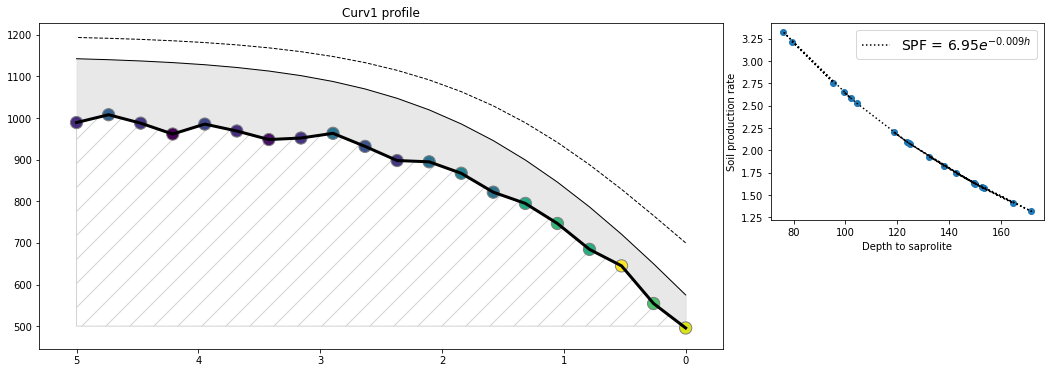

In [91]:
fig = plt.figure(figsize=(18,6))
gs = fig.add_gridspec(2,2, height_ratios=(1, 0.5), width_ratios=(2.5,1), wspace=0.1)
ax = fig.add_subplot(gs[:,0])
ax1 = fig.add_subplot(gs[0,1])

ax.plot(x, sap, color='k', linewidth=3) # soil-saprolite interface
ax.fill_between(x, 500, sap, facecolor='white', hatch='/', edgecolor='lightgrey') # color in bedrock


ax.plot(x, ss_surf, color='k', linewidth=1, linestyle='--') # FORMER sub-aerial soil interface

ax.plot(x, h1_curv1, color='k', linewidth=1) # NEW sub-aerial soil interface
ax.fill_between(x, sap, h1_curv1, alpha=0.5, color='lightgrey') # color in soil

# Scatter plot of soil production rates ---------------------------------------

ax.scatter(x, sap, c=ss['c1_spr'], s=150, edgecolor='grey')

# Plot params ---------------------------------------------------------------------

ax.invert_xaxis()
#ax.set_axis_off()
ax.set_title('Curv1 profile')

# SPF plot ---------------------------------------------------------------------

ax1.plot(ss['c1'], ss['c1_spr'], marker='o', linestyle='')
ax1.plot(ss['c1'], fit(ss['c1'], *c1_popt), 'k:', label=c1_fit)

ax1.set_xlabel('Depth to saprolite')
ax1.set_ylabel('Soil production rate')
ax1.legend(fontsize=14)

plt.show()

### Surface soil removed, new soil mantle f(curv2):

In [92]:
c2_popt, c2_pcov = curve_fit(fit, ss['c2'], ss['c2_spr'], p0=(200,-0.01))
print ("curve fit parameters a, k:", c2_popt)

curve fit parameters a, k: [6.9545348  0.00969697]


In [93]:
c2_fit = 'SPF = $6.95e^{-0.009h}$'

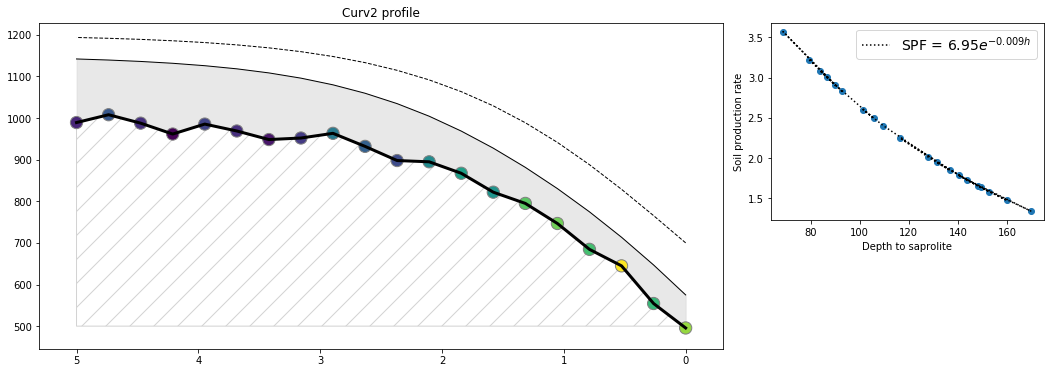

In [94]:
fig = plt.figure(figsize=(18,6))
gs = fig.add_gridspec(2,2, height_ratios=(1, 0.5), width_ratios=(2.5,1), wspace=0.1)
ax = fig.add_subplot(gs[:,0])
ax1 = fig.add_subplot(gs[0,1])

ax.plot(x, sap, color='k', linewidth=3) # soil-saprolite interface
ax.fill_between(x, 500, sap, facecolor='white', hatch='/', edgecolor='lightgrey') # color in bedrock


ax.plot(x, ss_surf, color='k', linewidth=1, linestyle='--') # FORMER sub-aerial soil interface

ax.plot(x, h1_curv2, color='k', linewidth=1) # NEW sub-aerial soil interface
ax.fill_between(x, sap, h1_curv2, alpha=0.5, color='lightgrey') # color in soil

# Scatter plot of soil production rates ---------------------------------------

ax.scatter(x, sap, c=ss['c2_spr'], s=150, edgecolor='grey')

# Plot params ---------------------------------------------------------------------

ax.invert_xaxis()
#ax.set_axis_off()
ax.set_title('Curv2 profile')

# SPF plot ---------------------------------------------------------------------

ax1.plot(ss['c2'], ss['c2_spr'], marker='o', linestyle='')
ax1.plot(ss['c2'], fit(ss['c2'], *c2_popt), 'k:', label=c2_fit)

ax1.set_xlabel('Depth to saprolite')
ax1.set_ylabel('Soil production rate')
ax1.legend(fontsize=14)

plt.show()

### Surface soil removed, new soil mantle f(curv3):

In [95]:
c3_popt, c3_pcov = curve_fit(fit, ss['c3'], ss['c3_spr'], p0=(200,-0.01))
print ("curve fit parameters a, k:", c3_popt)

curve fit parameters a, k: [6.9545348  0.00969697]


In [96]:
c3_fit = 'SPF = $6.95e^{-0.009h}$'

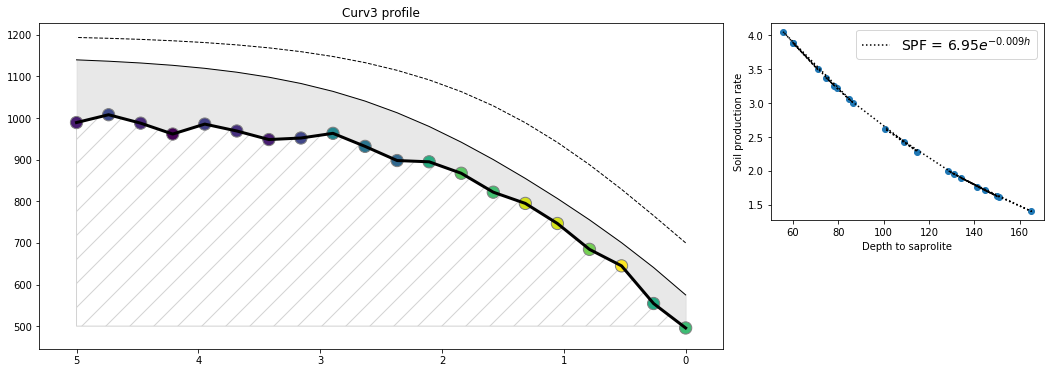

In [97]:
fig = plt.figure(figsize=(18,6))
gs = fig.add_gridspec(2,2, height_ratios=(1, 0.5), width_ratios=(2.5,1), wspace=0.1)
ax = fig.add_subplot(gs[:,0])
ax1 = fig.add_subplot(gs[0,1])

ax.plot(x, sap, color='k', linewidth=3) # soil-saprolite interface
ax.fill_between(x, 500, sap, facecolor='white', hatch='/', edgecolor='lightgrey') # color in bedrock


ax.plot(x, ss_surf, color='k', linewidth=1, linestyle='--') # FORMER sub-aerial soil interface

ax.plot(x, h1_curv3, color='k', linewidth=1) # NEW sub-aerial soil interface
ax.fill_between(x, sap, h1_curv3, alpha=0.5, color='lightgrey') # color in soil

# Scatter plot of soil production rates ---------------------------------------

ax.scatter(x, sap, c=ss['c3_spr'], s=150, edgecolor='grey')

# Plot params ---------------------------------------------------------------------

ax.invert_xaxis()
#ax.set_axis_off()
ax.set_title('Curv3 profile')

# SPF plot ---------------------------------------------------------------------

ax1.plot(ss['c3'], ss['c3_spr'], marker='o', linestyle='')
ax1.plot(ss['c3'], fit(ss['c3'], *c3_popt), 'k:', label=c3_fit)

ax1.set_xlabel('Depth to saprolite')
ax1.set_ylabel('Soil production rate')
ax1.legend(fontsize=14)

plt.show()

### SPF plot for C1-C3

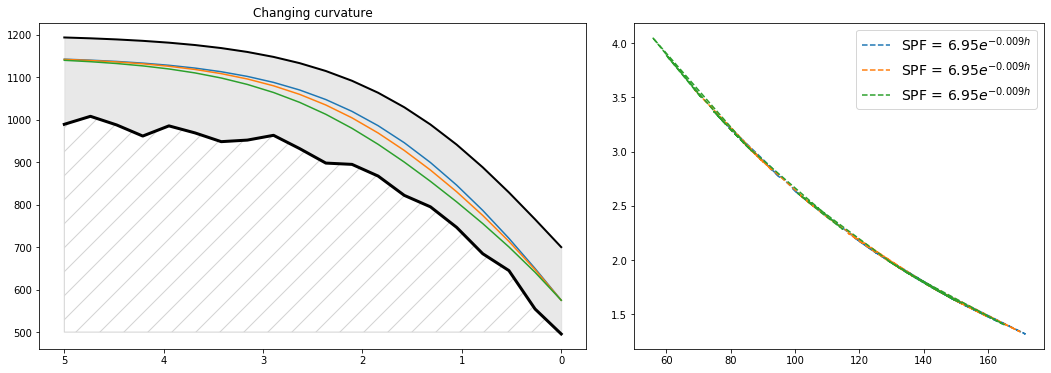

In [98]:
fig = plt.figure(figsize=(18,6))
gs = fig.add_gridspec(2,2, height_ratios=(1, 0.5), width_ratios=(1,0.75), wspace=0.1)
ax = fig.add_subplot(gs[:,0])
ax1 = fig.add_subplot(gs[:,1])

# Plot initial conditions -------------------------------------------------
ax.plot(x, sap, color='k', linewidth=3) # soil-saprolite interface
ax.fill_between(x, 500, sap, facecolor='white', hatch='/', edgecolor='lightgrey') # color in bedrock


ax.plot(x, ss_surf, color='k', linewidth=2) # sub-aerial soil interface
ax.fill_between(x, sap, ss_surf, alpha=0.5, color='lightgrey') # color in soil

ax.plot(x, h1_curv1)
ax.plot(x, h1_curv2)
ax.plot(x, h1_curv3)

ax.invert_xaxis()
#ax.set_axis_off()
ax.set_title('Changing curvature')

# SPF plot ---------------------------------------------------------------------

ax1.plot(ss['c1'], fit(ss['c1'], *c1_popt), '--', label=c1_fit)
ax1.plot(ss['c2'], fit(ss['c2'], *c2_popt), '--', label=c2_fit)
ax1.plot(ss['c3'], fit(ss['c3'], *c3_popt), '--', label=c3_fit)

ax1.legend(fontsize=14)

plt.show()